# 1. S-BERT
- Sentence-BERT is a modification of BERT.
    - Sentence Embeddings using Siamese BERT-Networks
- SBERT combines the power of BERT with the efficiency required for large-scale semantic tasks.

## 1.1 sentence level tasks

Two tasks examples:

* **NLI (natural language inferencing)** → decide if a hypothesis "entailment", "contradicts", or is "neutral" with respect to a premise.
    * **entailment**: s1 entails s2;
    * **contradiction**: s1 contradicts s2;
    * **neutral**: s1 and s2 have no relation;
* **STS (semantic textual similarity)** → measure how similar two sentences are in meaning, often scored on a continuous scale.

Other examples:

* **Paraphrase identification** → detect whether two sentences express the same meaning.
* **Information retrieval / semantic search** → retrieve the most relevant sentences or passages given a query.

## 1.2 demos
paraphrase-MiniLM-L6-v2 -> STS \
encode: sentence -> embedding

In [1]:
from sentence_transformers import SentenceTransformer, util

embed_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

embed_1 = embed_model.encode('the tennis game is awesome!', convert_to_tensor=True)
embed_2 = embed_model.encode('positive', convert_to_tensor=True)

cos_sim = util.pytorch_cos_sim(embed_1, embed_2).item()
print("similarity between embed_1 and embed_2: ", cos_sim)

embed_3 = embed_model.encode('negative', convert_to_tensor=True)

cos_sim = util.pytorch_cos_sim(embed_1, embed_3).item()
print("similarity between embed_1 and embed_3: ", cos_sim)

similarity between embed_1 and embed_2:  0.16334792971611023
similarity between embed_1 and embed_3:  -0.09728436917066574


## 1.3 model

### 1.3.1 BERT
- Pre-training tasks:
     - MLM (predicting masked words),
     - NSP (determining sentence relationships).
- Downstream tasks (fine-tuning) -> Add a head:
    - Sentiment analysis,
    - intent analysis,
    - NLI,
    - QA,
    - NER,
    - etc....

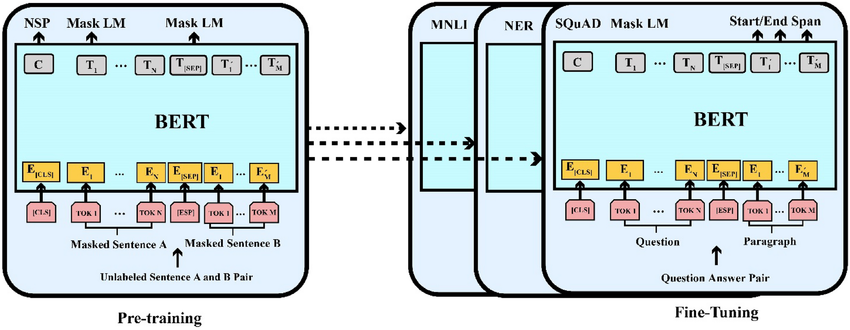

In [2]:
from IPython.display import Image
Image(filename='../tutorials/samples/bert.png')

- BERT is very effective at modeling token-level semantics because of its masked language modeling pretraining. 
- However, it is not naturally designed to produce meaningful sentence embeddings, so using the [CLS] token or averaging token vectors often results in poor performance.
    - The NSP task is to determine whether sentence B is the next sentence of sentence A -> Two-class classification task
        - This task only requires the model to learn the coherence and relevance between sentences, rather than accurately capturing the complete semantic information of the sentences.
- These naive embeddings perform almost as poorly as static word embeddings like GloVe when applied to sentence-level tasks such as similarity or classification.
- **Sentence-BERT (SBERT)** addresses this limitation by fine-tuning BERT in a Siamese setup, enabling it to generate high-quality sentence embeddings suitable for semantic similarity, clustering, and retrieval tasks.

- BERT: Encoder + Multiple Task Heads → Emphasizes token-level representations,
    - requiring downstream support (classification layers, pointer networks, etc.).
- SBERT: Encoder + Pooling → Emphasizes sentence-level embeddings,
    - with the goal of training to make the embedding space directly usable for similarity/retrieval.

### 1.3.2 Traning BERT on NLI (classification objective)

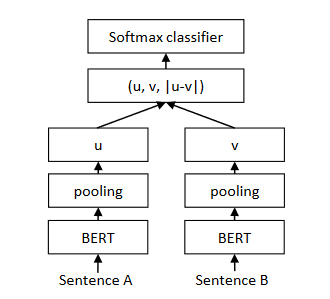

In [3]:
Image(filename='../tutorials/samples/siamese_network_nli.png', width=300)

### 1.3.3 Training BERT STS (regression objective)

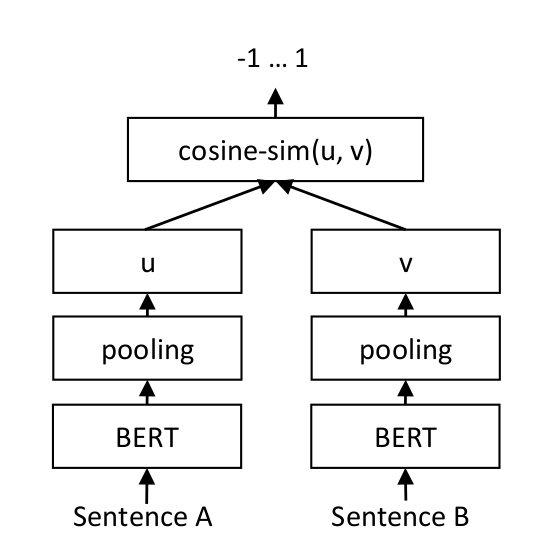

In [4]:
Image(filename='../tutorials/samples/siamese_network_sts.png', width=300)

### 1.3.4 Training BERT on Triplet dataset (triplet objective)
Three input

## 1.4 pretrain demo

### 1.4.1 models

In [5]:
from sentence_transformers import SentenceTransformer, models

word_embed_model = models.Transformer('bert-base-uncased')

pooling_model = models.Pooling(
    word_embed_model.get_word_embedding_dimension(),
    pooling_mode='cls', # cls, mean, max
    pooling_mode_cls_token=True,
    pooling_mode_mean_tokens=False
)

model = SentenceTransformer(modules=[word_embed_model, pooling_model])

### 1.4.2 Data and tasks
- Dataset -> glue mrpc
    - GLUE (General Language Understanding Evaluation)
    - MRPC (Microsoft Research Paraphrase Corpus)
- Determine whether 2 sentences have the same meaning.

In [6]:
from datasets import load_dataset

dataset = load_dataset("glue", "mrpc")

In [7]:
dataset['train'][0]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0}

InputExample -> encapsulated tokenizer

### 1.4.3 training loss

In [17]:
from torch.utils.data import DataLoader
from sentence_transformers import losses
from sentence_transformers import InputExample

train_examples = [
    InputExample(texts=['This is a positive pair', 'I really love this world'], label=1),
    InputExample(texts=['This is a negative pair', 'I am not a big fan of this world'], label=0)]

train_loader = DataLoader(train_examples, shuffle=True, batch_size=2)
train_loss = losses.ContrastiveLoss(model=model)

### 1.4.4 training

In [12]:
from sentence_transformers import evaluation

s1s = []
s2s = []
scores = []

for example in dataset['validation']:
    s1s.append(example['sentence1'])
    s2s.append(example['sentence2'])
    scores.append(float(example['label']))

evaluator = evaluation.BinaryClassificationEvaluator(s1s, s2s, scores)

In [13]:
model.fit(
    train_objectives=[(train_loader, train_loss)],
    evaluator=evaluator,
    evaluation_steps=200,
    epochs=5,
    warmup_steps=0,
    output_path='./sentence_transformer/',
    weight_decay=0.01,
    optimizer_params={'lr': 0.00004},
    save_best_model=True,
    show_progress_bar=True,
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

/opt/miniconda3/envs/bert/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss,Cosine Accuracy,Cosine Accuracy Threshold,Cosine F1,Cosine F1 Threshold,Cosine Precision,Cosine Recall,Cosine Ap,Cosine Mcc
1,No log,No log,0.698529,0.843945,0.813411,0.578639,0.685504,1.000000,0.837965,0.072897
2,No log,No log,0.698529,0.838350,0.813411,0.553023,0.685504,1.000000,0.836266,0.072897
3,No log,No log,0.700980,0.822078,0.813411,0.558362,0.685504,1.000000,0.836729,0.072897
4,No log,No log,0.696078,0.834430,0.813411,0.575101,0.685504,1.000000,0.836872,0.072897
5,No log,No log,0.698529,0.837874,0.813411,0.584287,0.685504,1.000000,0.836732,0.072897


/opt/miniconda3/envs/bert/lib/python3.10/site-packages/sentence_transformers/util/tensor.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  a = torch.tensor(a)
/opt/miniconda3/envs/bert/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/miniconda3/envs/bert/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/miniconda3/envs/bert/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin

### 1.4.5 test

In [14]:
sentences = ['This is just a random sentence on a friday evening',
             'to test model ability.']

embeddings = model.encode(sentences)
embeddings

array([[ 0.21705273,  0.13207799,  0.16603419, ..., -0.14641964,
         0.2952229 ,  0.4511513 ],
       [-0.33327833,  0.07570648, -0.43999773, ..., -0.4300585 ,
         0.08745298,  0.5565507 ]], shape=(2, 768), dtype=float32)

In [15]:
from sentence_transformers import util

correct = 0
for row in dataset['test']:
    u = model.encode(row['sentence1'])
    v = model.encode(row['sentence2'])
    cos_score = util.cos_sim(u, v)[0].numpy()[0]
    if cos_score > 0.5 and row['label'] == 1:
        correct += 1
    if cos_score <= 0.5 and row['label'] == 0:
        correct += 1

In [16]:
print(correct / len(dataset['test']))

0.6643478260869565


---
# 2. S-BERT source code analytics

In [1]:
import torch
import torch.nn.functional as F
from copy import deepcopy

In [2]:
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, InputExample, models
from torch.utils.data import DataLoader

model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## 2.1 model
- BertModel
- Pooling
- Norm

In [3]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

## 2.2 dataloader
- **InputExample** is like a card, each containing a piece of training data (sentence + label).
    - Many cards make up a training set, which is fed into the model stack by stack during training,
        - allowing the model to learn the relationships between sentences.

In [13]:
train_examples = [
    InputExample(
        texts=['This is a positive pair', 'I really love this world'],
        label=1
    ),
]

In [14]:
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=2)

- **collate_fn**: 
    - It is a "packaging function" in PyTorch DataLoader, responsible for combining a stack of InputExample (cards) into a batch tensor.
- **model.smart_batching_collate**
    - has integrates tokenizer

In [17]:
train_dataloader.collate_fn = model.smart_batching_collate
batch = next(iter(train_dataloader))
batch

([{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3893, 3940,  102]]),
   'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]),
   'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])},
  {'input_ids': tensor([[ 101, 1045, 2428, 2293, 2023, 2088,  102]]),
   'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0]]),
   'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}],
 tensor([1]))

## 2.3 losses

### Formula

For a pair of embeddings $u, v$ and label $y \in \{0,1\}$:

$$
L(u, v) = y \cdot D(u, v)^2 \;+\; (1-y) \cdot \max\big(0, m - D(u, v)\big)^2
$$

* $D(u, v) = \| u - v \|_2$ = Euclidean distance between the two embeddings
* $y = 1$: positive pair (similar sentences)
* $y = 0$: negative pair (dissimilar sentences)
* $m$: margin hyperparameter (minimum distance enforced between negative pairs)

In [18]:
train_loss = losses.ContrastiveLoss(model=model)

## 2.4 model.forward

In [22]:
features, labels = batch

In [23]:
model[1](model[0](features[0]))['sentence_embedding'][0, :5]

tensor([-0.2930,  0.3243, -0.6169, -0.0097, -0.1806], grad_fn=<SliceBackward0>)

## 2.5 forward loss

In [26]:
sent1_embed = model(features[0])['sentence_embedding']
sent2_embed = model(features[1])['sentence_embedding']

train_loss.distance_metric(sent1_embed, sent2_embed)

tensor([0.9148], grad_fn=<RsubBackward1>)

In [27]:
train_loss(features, labels)

tensor(0.4184, grad_fn=<MeanBackward0>)

## 2.6 Poolng methods

### 2.6.1 pooling_mode_mean_tokens

In [29]:
train_examples = [
    InputExample(
        texts=['This is a positive pair', 'I really love this world'],
        label=1
    ),
]

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=2)
train_dataloader.collate_fn = model.smart_batching_collate
batch = next(iter(train_dataloader))

features, labels = batch

In [32]:
word_embed_model = models.Transformer('bert-base-uncased')

pooling_model = models.Pooling(
    word_embed_model.get_word_embedding_dimension(),
    pooling_mode_cls_token=False,
    pooling_mode_mean_tokens=True,
    pooling_mode_max_tokens=False,
    pooling_mode_mean_sqrt_len_tokens=False
)